In [708]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(3456)

#### Hidden Layer: $h_j = \max{(W^{y}y_{j} + W^{t}t_{j} + W^{h}h_{j-1} + b_{h},0)} $


#### Marker Generation: $P(y_{j+1}=k\mid h_{j}) = \frac{\exp(V_{k,:}^{y}h_{j} + b_{k}^{y})}{\sum_{k=1}^{K} \exp(V_{k,:}^{y}h_{j} + b_{k}^{y})} = \sigma(z)_{k}$ where $\sigma$ is softmax function and $z$ is the vector $ V^{y}h_{j} + b^{y}$ 


#### Conditional Density: $f^{*}(t) = \exp\{{v^{t}}^\top.h_{j} + w^t(t-t_{j}) + b^{t} + \frac{1}{w}\exp({v^{t}}^\top.h_{j} + b^{t}) -\frac{1}{w}\exp({v^{t}}^\top.h_{j} + w^t(t-t_{j}) + b^{t} )\} $

In [801]:
class Rmtpp(nn.Module):
    
    def __init__(self,marker_dim):
        #marker_dim equals to time_dim
        super(Rmtpp, self).__init__()
       
        #linear transformation
        self.lin_op = nn.Linear(3,1) 
        self.vt = nn.Linear(1,1)
        
        #weights
        self.w_t = torch.rand(1)
        self.w = torch.rand(1)
        self.V_y = torch.rand(marker_dim) #marker dim = number of markers 
        self.b_y = torch.rand(marker_dim) #bias
        
    #compute integral of t*fstart(t) between tj and +infinity using monteCarlo method
    def numerical_mean(self,tj,hj):  
        N = 10000
        samp = torch.randn(N,1)
        sample = (samp>tj).float() * torch.sqrt(torch.tensor([2*F.math.pi]*N).unsqueeze(-1)) * torch.exp(1/2 * samp**2) * samp * self.fstart(samp,tj,hj)
        #I select only value greater than tj
        samp = samp.squeeze(1)
        sample = sample.squeeze(1)
        samp = samp>tj 
        samp = samp.float()
        sample = torch.dot(samp,sample) 
        #then cumsum of sample 
        return torch.cumsum(sample,dim=0)
    
    #compute integral of lambda*(t) between tj and t using trapezoidal method
    def numerical_integration(self,tj,t,hj):
        N = 1000
        print("1",tj)
        print(t.size())
        tsteps = torch.linspace(tj,t,step=N)
        y = [self.lambda_star(t,tj,hj) for t in tsteps]
        y = torch.tensor(y)
        delta_t = (t - tj)/N
        return delta_t * sum((y[1:]+y[:-1]))/2
        
        
    #compute the function lambdastar  
    def lambda_star(self,t,tj,hj):
        return torch.exp(self.vt(hj) - torch.exp(self.w_t)*(t-tj))
    
    #compute the function fstar
    def fstart(self,t,tj,hj):
        return self.lambda_star(t,tj,hj)*torch.exp(-1*self.numerical_integration(tj,t,hj)) 
    
          
        
    def forward(self, time, marker, hidden_state):
        print('-'*5,'***','-'*5)
        #I first compute next time
        tj = time
        time = self.numerical_mean(time,hidden_state)
        logfstar = -1 * torch.log(self.fstart(time,tj,hidden_state))
        
        #Then next marker distribution
        soft_max = nn.LogSoftmax(dim=0) #softmax of rows
        logprob = -1 * soft_max(self.V_y*hidden_state + self.b_y) 
        
        #Finally next hidden_state
        input_ = torch.cat((marker, time.unsqueeze(-1), hidden_state))
        hidden_state = F.relu(self.lin_op(input_))
        
        #print('-'*5,'3','-'*5)
        return logprob, logfstar, hidden_state
    
    def init_hidden(self):
        return torch.zeros(1)
    
    def log_likelihood(self,log_time_series_list,log_marker_series_list):
        #time series and marker series are output of the RMTPP network
        #return log_likelihood of all sequences
        lll = 0
        for i in range(len(log_time_series_list)):
            lll += torch.sum(log_time_series_list) + torch.sum(log_marker_series_list)
        return lll       
                
        

In [800]:
t = torch.tensor([1,2,3,4,5,6,7])
m = torch.tensor([11,23,12,19,23,12,98])

(t<3).float()*m.float()
#n = (t<3) * torch.tensor([0]) + (t>3) *m

tensor([11., 23.,  0.,  0.,  0.,  0.,  0.])

## Training:

In [787]:
loss = nn.NLLLoss()
learning_rate = 0.0005
rnn = Rmtpp(10)


def train(time,marker):
    #time and marker are list object
    time = torch.tensor(time).unsqueeze(-1)
    marker = torch.tensor(marker).unsqueeze(-1).float()
    loss = 0
    hidden = rnn.init_hidden()
    lp = []
    lf = []
    for j in range(len(time)):
        tj = time[j]
        yj = marker[j]
        logprob, logfstar, hidden = rnn(tj, yj, hidden)
        
        lp.append(logprob)
        lf.append(logfstar)


time,marker = simulate_timestamps(5)
train(time,marker)  



----- *** -----
tj : tensor([0.1454])
1 tensor([0.1454])
torch.Size([10000, 1])


TypeError: linspace() received an invalid combination of arguments - got (Tensor, Tensor, step=int), but expected one of:
 * (Number start, Number end, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool requires_grad)
 * (Number start, Number end, int steps, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool requires_grad)


# Tick.Hawkes

In [575]:
from tick.plot import plot_point_process
from tick.hawkes import SimuHawkes, HawkesKernelSumExp

#### 1 dimensional Hawkes process simulation using tick

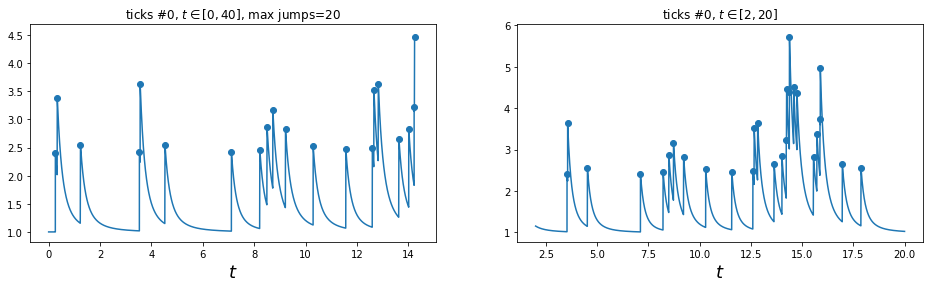

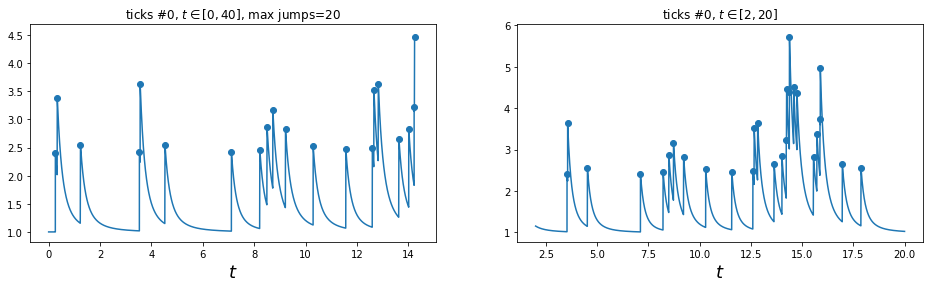

In [576]:
run_time = 40

hawkes = SimuHawkes(n_nodes=1, end_time=run_time, verbose=False, seed=1398)
kernel1 = HawkesKernelSumExp([.1, .2, .1], [1., 3., 7.])
hawkes.set_kernel(0, 0, kernel)
hawkes.set_baseline(0, 1.)

dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()
timestamps = hawkes.timestamps
intensity = hawkes.tracked_intensity
intensity_times = hawkes.intensity_tracked_times

_, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_point_process(hawkes, n_points=50000, t_min=0, max_jumps=20, ax=ax[0])
plot_point_process(hawkes, n_points=50000, t_min=2, t_max=20, ax=ax[1])

In [651]:
def simulate_timestamps(end_time):
    # simulation 2 types of event for exemple selling or buying
    
    hawkes = SimuHawkes(n_nodes=2, end_time=end_time, verbose=False, seed=1398)
    kernel = HawkesKernelSumExp([.1, .2, .1], [1., 3., 7.])
    kernel1 = HawkesKernelSumExp([.2, .3, .1], [1., 3., 7.])
    
    hawkes.set_kernel(0, 0, kernel)
    hawkes.set_kernel(0, 1, kernel)
    hawkes.set_kernel(1, 0, kernel)
    hawkes.set_kernel(1, 1, kernel)
    
    hawkes.set_baseline(0, .8)
    hawkes.set_baseline(1, 1.)

    dt = 0.1
    hawkes.track_intensity(dt)
    hawkes.simulate()
    timestamps = hawkes.timestamps
    t0 = timestamps[0]
    t1 = timestamps[1]
    
    t = []
    marker = []
    n0 = len(t0)
    n1 = len(t1)
    i = 0
    j = 0
    while(i<n0 and j<n1):
        if(t0[i]<t1[j]):
            t.append(t0[i])
            marker.append(0)
            i += 1
        else:
            t.append(t1[j])
            marker.append(1)
            j += 1
    if(i==n0):
        for k in range(n0,n1):
            t.append(t1[k])
            marker.append(1)
    else:
        for k in range(n1,n0):
            t.append(t0[k])
            marker.append(0)
        
        
   
    return t,marker


 

In [657]:
#simulate_timestamps(end_time=20)[0]